# Krótkie wprowadzenie do sieci PFN (Prior-data Fitted Networks)

## Wykorzystywane biblioteki

Będziemy używać jedynie standardowych bibliotek do uczenia maszynowego: NumPy, PyTorch,
Scikit-learn, Matplotlib i tqdm do logowania postępów uczenia. Jeśli używasz środowiska Google Colab
to wszystkie wymienione biblioteki powinny być domyślnie zainstalowane i dostępne. Jeżeli jednak
korzystasz z własnego komputera to wykonanie poniższej komórki zainstaluje wymagane biblioteki (z
wyjątkiem PyTorcha) za pomocą Pip'a. Instalacja PyTorcha wymaga osobnej instrukcji - szczegółowe
informacje znajdziesz na stronie: [PyTorch - Get Started](https://pytorch.org/get-started/locally/).

Klikając w poniższy link możesz otworzyć ten notebook bezpośrednio w środowisku Google Colab

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/barhanc/nn-core/blob/main/notebooks/pfn-tutorial.ipynb)

Notebook był testowany na Pythonie 3.12.

In [1]:
# %pip install numpy scikit-learn matplotlib tqdm

In [2]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from torch import Tensor

In [3]:
from typing import TypeAlias

DeviceLikeType: TypeAlias = str | torch.device

if torch.cuda.is_available():
    device = "cuda"
elif torch.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Using device: {device.upper()}")

Using device: CUDA


## Wprowadzenie teoretyczne

In [4]:
class BernoulliPFN(nn.Module):
    def __init__(
        self,
        num_features: int,
        dim_model: int,
        dim_feedforward: int,
        num_heads: int,
        num_encoder_layers: int,
        num_decoder_layers: int,
    ):
        super().__init__()
        self.num_features = num_features
        self.map_src_X = nn.Linear(num_features, dim_model)
        self.map_tgt_X = nn.Linear(num_features, dim_model)
        self.map_src_y = nn.Linear(1, dim_model)
        self.map_out = nn.Sequential(
            nn.Linear(dim_model, dim_feedforward),
            nn.GELU(),
            nn.Linear(dim_feedforward, 1),
        )
        self.transformer = nn.Transformer(
            d_model=dim_model,
            nhead=num_heads,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            activation="gelu",
            batch_first=True,
        )

    def forward(self, X_train: Tensor, y_train: Tensor, X_query: Tensor) -> Tensor:
        """
        Args:
            X_train (Tensor): Shape `(batch_size, train_size, num_features)`
            y_train (Tensor): Shape `(batch_size, train_size, 1)`
            X_query (Tensor): Shape `(batch_size, query_size, num_features)`

        Returns:
            Tensor: Shape `(batch_size, query_size, 1)`
        """
        assert X_train.ndim == 3
        assert y_train.ndim == 3
        assert X_query.ndim == 3
        assert X_train.size(0) == y_train.size(0) == X_query.size(0)
        assert X_train.size(2) == X_query.size(2) == self.num_features
        assert X_train.size(1) == y_train.size(1)
        assert y_train.size(2) == 1

        query_size = X_query.size(1)

        tgt_mask = -torch.eye(query_size) + 1.0
        tgt_mask[tgt_mask == 1.0] = -torch.inf

        src = self.map_src_X(X_train) + self.map_src_y(y_train)
        tgt = self.map_tgt_X(X_query)
        out = self.transformer(src, tgt, tgt_mask=tgt_mask.to(tgt))
        out = self.map_out(out)

        return out

    @torch.no_grad()
    def predict_proba(self, X_train: Tensor, y_train: Tensor, X_query: Tensor) -> Tensor:
        """
        Args:
            X_train (Tensor): Shape `(train_size, num_features)`
            y_train (Tensor): Shape `(train_size, 1)`
            X_query (Tensor): Shape `(query_size, num_features)`

        Returns:
            Tensor: Shape `(query_size, 1)`
        """
        self.eval()

        X_train = X_train.unsqueeze(0)
        y_train = y_train.unsqueeze(0)
        X_query = X_query.unsqueeze(0)

        logits: Tensor = self(X_train, y_train, X_query)

        return logits.sigmoid().squeeze(0)

    def predict(self, X_train: Tensor, y_train: Tensor, X_query: Tensor, threshold: float = 0.5) -> Tensor:
        """
        Args:
            X_train (Tensor): Shape `(train_size, num_features)`
            y_train (Tensor): Shape `(train_size, 1)`
            X_query (Tensor): Shape `(query_size, num_features)`
            threshold (float): Probability value, used to convert probabilistic outputs into
                               concrete class labels.

        Returns:
            Tensor: Shape `(query_size, 1)`
        """
        return self.predict_proba(X_train, y_train, X_query) > threshold

In [5]:
from matplotlib.axes import Axes
from matplotlib.lines import Line2D


def plot_pfn_decision_boundary(
    ax: Axes,
    pfn: BernoulliPFN,
    X_train: Tensor,
    X_query: Tensor,
    y_train: Tensor,
    y_query: Tensor,
    device: DeviceLikeType,
) -> None:
    assert X_train.ndim == 2
    assert X_query.ndim == 2
    assert y_train.ndim == 2
    assert y_query.ndim == 2
    assert X_train.size(1) == 2
    assert X_query.size(1) == 2
    assert y_train.size(1) == 1
    assert y_query.size(1) == 1

    # --- Compute mesh limits ---
    x_min = min(X_train[:, 0].min().item(), X_query[:, 0].min().item())
    x_max = max(X_train[:, 0].max().item(), X_query[:, 0].max().item())
    y_min = min(X_train[:, 1].min().item(), X_query[:, 1].min().item())
    y_max = max(X_train[:, 1].max().item(), X_query[:, 1].max().item())

    margin_x = 0.05 * (x_max - x_min)
    margin_y = 0.05 * (y_max - y_min)

    x_min -= margin_x
    x_max += margin_x
    y_min -= margin_y
    y_max += margin_y

    # --- Compute probability values at mesh points ---
    steps = 50
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, steps), np.linspace(y_min, y_max, steps))
    mesh = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float().to(device)

    probas = pfn.predict_proba(X_train, y_train, mesh).cpu().numpy()
    probas = probas.reshape(xx.shape)

    # --- Plot probability contours ---
    ax.contourf(xx, yy, probas, alpha=0.3, cmap="PiYG")
    cs = ax.contour(xx, yy, probas, cmap="PiYG")
    ax.clabel(cs, inline=True, fontsize=8)

    # --- Plot training and query points ---
    ax.scatter(
        X_train.cpu().numpy()[:, 0],
        X_train.cpu().numpy()[:, 1],
        c=y_train.cpu().numpy().flatten(),
        edgecolors="gold",
        cmap="PiYG",
    )

    ax.scatter(
        X_query.cpu().numpy()[:, 0],
        X_query.cpu().numpy()[:, 1],
        c=y_query.cpu().numpy().flatten(),
        edgecolors="k",
        cmap="PiYG",
    )

    train_handle = Line2D(
        [],
        [],
        marker="o",
        color="w",
        markerfacecolor="none",
        markeredgecolor="gold",
        markersize=8,
        label="Train",
    )
    query_handle = Line2D(
        [],
        [],
        marker="o",
        color="w",
        markerfacecolor="none",
        markeredgecolor="k",
        markersize=8,
        label="Test",
    )
    ax.legend(handles=[train_handle, query_handle], loc="best")


def plot_loss_hist(ax: Axes, loss_hist: list[float], ylabel: str = "") -> None:
    ax.plot(loss_hist)
    ax.set_xlabel("Epoch")
    ax.set_ylabel(ylabel)
    ax.grid(True)

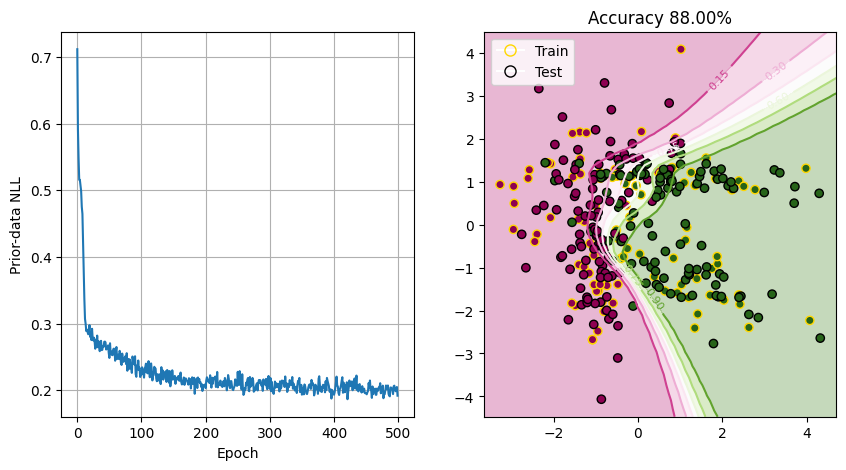

Epoch   500 | Loss 0.192: 100%|██████████| 500/500 [03:42<00:00,  2.25it/s]


In [6]:
from tqdm import trange
from IPython.display import clear_output, display
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification, make_blobs

# NOTE: If you don't have access to a GPU or you're having difficulties to train the model in a
#       reasonble amount of time, change the prior to a simpler one like `make_blobs` with
#       `centers=2` (for binary classification) and lower the number of epochs to ~200.

# --- Define prior distribution over binary classification tasks ---
# sample_prior = lambda n_samples: make_blobs(n_samples, centers=2)
sample_from_prior = lambda n_samples: make_classification(n_samples, n_features=2, n_redundant=0)

# --- Define training parameters ---
batch_size = 256
num_epochs = 500

train_size = 100  # TODO: ...
query_size = 50  # TODO:...
n_samples = train_size + query_size

# --- Define model ---
pfn = BernoulliPFN(
    num_features=2,
    dim_model=256,
    dim_feedforward=512,
    num_heads=8,
    num_decoder_layers=2,
    num_encoder_layers=2,
).to(device)

# --- Define optimizer ---
optimizer = torch.optim.AdamW(pfn.parameters(), lr=3e-4)

#
loss_hist: list[float] = []

X_fixed, y_fixed, *_ = sample_from_prior(300)

X_fixed = torch.from_numpy(X_fixed).float().to(device)
y_fixed = torch.from_numpy(y_fixed).float().unsqueeze(-1).to(device)

X_train_fixed = X_fixed[:train_size, :]
X_query_fixed = X_fixed[train_size:, :]
y_train_fixed = y_fixed[:train_size, :]
y_query_fixed = y_fixed[train_size:, :]

fixed_data = (X_train_fixed, X_query_fixed, y_train_fixed, y_query_fixed)

visualize: bool = True
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))


# ################################################
# ##########     Training Loop     ###############
# ################################################

for epoch in (pbar := trange(num_epochs)):
    pfn.train()
    # --- Sample a batch of classification tasks from the prior ---
    data = [sample_from_prior(n_samples) for _ in range(batch_size)]

    X, y = zip(*data)
    X, y = np.stack(X), np.stack(y)
    X, y = torch.from_numpy(X).float(), torch.from_numpy(y).float().unsqueeze(-1)
    X, y = X.to(device), y.to(device)

    X_train, y_train = X[:, :train_size, :], y[:, :train_size, :]
    X_query, y_query = X[:, train_size:, :], y[:, train_size:, :]

    # --- Train model ---
    logits = pfn(X_train, y_train, X_query)
    loss = F.binary_cross_entropy_with_logits(logits, y_query)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # --- Log progress ---
    loss_hist.append(loss.item())
    pbar.set_description(f"Epoch {epoch+1:>5d} | Loss {loss.item():.3f}")

    acc = accuracy_score(
        y_true=y_query_fixed.cpu().numpy(),
        y_pred=pfn.predict(X_train_fixed, y_train_fixed, X_query_fixed).cpu().numpy(),
    )

    if visualize:
        clear_output(wait=True)
        ax[0].clear()
        ax[1].clear()
        ax[1].set_title(f"Accuracy {acc:.2%}")
        plot_loss_hist(ax[0], loss_hist, ylabel="Prior-data NLL")
        plot_pfn_decision_boundary(ax[1], pfn, *fixed_data, device)
        display(fig)
        plt.close(fig)

Accuracy 93.00%


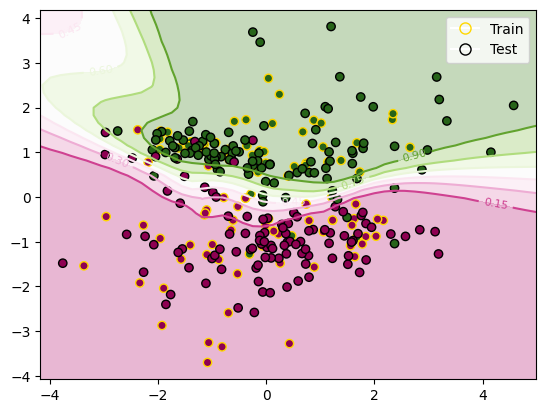

In [7]:
from sklearn.model_selection import train_test_split

data_X, data_y, *_ = sample_from_prior(n_samples=300)
X_train, X_query, y_train, y_query = train_test_split(data_X, data_y, train_size=train_size)

X_train = torch.from_numpy(X_train).float().to(device)
X_query = torch.from_numpy(X_query).float().to(device)
y_train = torch.from_numpy(y_train).unsqueeze(-1).float().to(device)
y_query = torch.from_numpy(y_query).unsqueeze(-1).float().to(device)

acc = accuracy_score(
    y_true=y_query.cpu().numpy(),
    y_pred=pfn.predict(X_train, y_train, X_query).cpu().numpy(),
)
print(f"Accuracy {acc:.2%}")

_, ax = plt.subplots()
plot_pfn_decision_boundary(ax, pfn, X_train, X_query, y_train, y_query, device)

Accuracy 88.50%


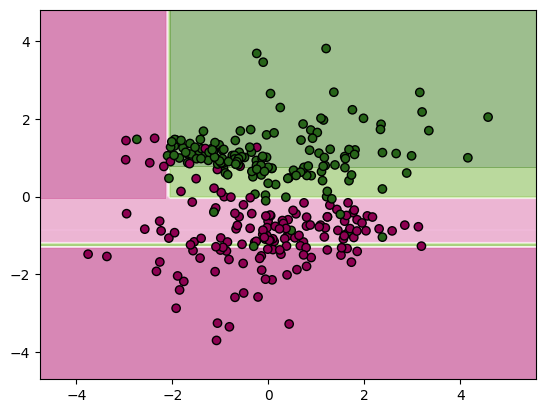

In [8]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import DecisionBoundaryDisplay

estimator = GradientBoostingClassifier()
param_grid = {
    "n_estimators": [50, 100, 500],
    "learning_rate": [0.01, 0.2, 1.0],
    "max_depth": [3, 5, 7, None],
}

clf = GridSearchCV(estimator, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
clf.fit(X_train.cpu().numpy(), y_train.cpu().numpy().squeeze())

acc = accuracy_score(
    y_true=y_query.cpu().numpy().squeeze(),
    y_pred=clf.predict(X_query.cpu().numpy()),
)
print(f"Accuracy {acc:.2%}")

disp = DecisionBoundaryDisplay.from_estimator(clf, data_X, cmap="PiYG", alpha=0.5)
disp.ax_.scatter(data_X[:, 0], data_X[:, 1], c=data_y, edgecolors="k", cmap="PiYG")
plt.show()